In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import non_negative_factorization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('autoreg_unsorted.csv')
df = df.T

In [6]:
def get_variance(X):
    '''
    Computes average L2 distance from each NMF-approximated column vector to the mean vector
    '''
    X_avg = np.array(X).mean(axis=1, keepdims=True)
    return np.mean(
        np.linalg.norm(X - X_avg, axis=0)
    )

In [8]:
def get_block_inds(df, block_sz):
    '''
    Returns the start/end indices for blocks to match np.array_split's rules, e.g.
    [(0, 101), (101, 202), ...] for block_sz = 100
    '''
    block_inds = np.array_split(
        np.arange(0, df.shape[1]),
        df.shape[1] // block_sz
    )
    edge_inds = [(blk[0], blk[-1] + 1) for blk in block_inds]
    return edge_inds


In [54]:
def block_nmf(df, block_sz, variance_cutoff, max_components=50):
    '''
    Run NMF on blocks of the input dataframe.
    Params:
    block_sz: Number of time points in each block.
    variance_cutoff: Run NMF on a block until at least this percentage of variance is explained.
    max_components: Hard cut-off for how many components to run NMF on (to save time). 
    '''
    max_components = min(block_sz, max_components)
    block_inds = get_block_inds(df, block_sz)
    blocks = np.array_split(
        df, 
        df.shape[1] // block_sz,
        axis=1
    )
    # nmf_vars[i][j] = NMF variance on i'th block using j+1 components
    nmf_vars = [[] for _ in range(len(blocks))]
    true_vars = []
    components_needed = []
    for blk_i, blk in enumerate(blocks):
        # print(f"Block #: {blk_i}")
        l, r = block_inds[blk_i]
        true_var = get_variance(df.iloc[:, l:r])
        true_vars.append(true_var)
        for num_comps in range(1, max_components + 1):
            W, H, _ = non_negative_factorization(
                blk,
                n_components=num_comps,
                max_iter=20000,
                init='nndsvd'
            ) # Run NMF
            X_hat = W @ H
            var = get_variance(X_hat)
            nmf_vars[blk_i].append(var)
            # print(f"# components: {num_comps}")
            if var >= variance_cutoff or num_comps == max_components: 
                components_needed.append(num_comps)
                break
        nmf_vars[blk_i].append(var)
    return nmf_vars, true_vars, components_needed
        

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


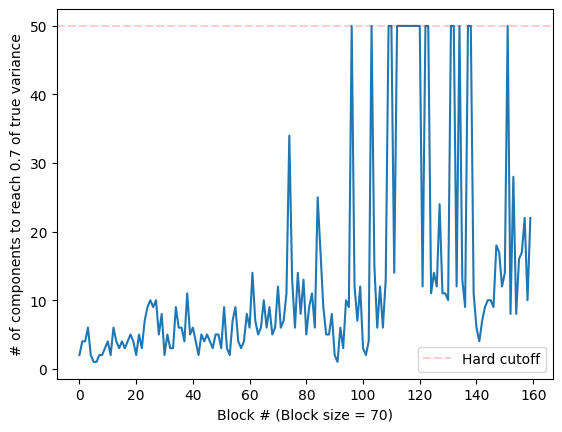

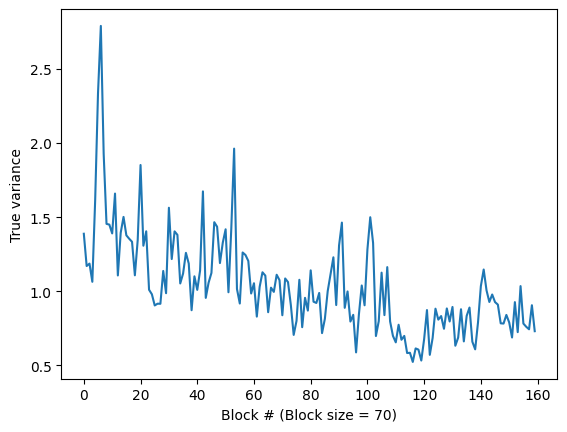

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


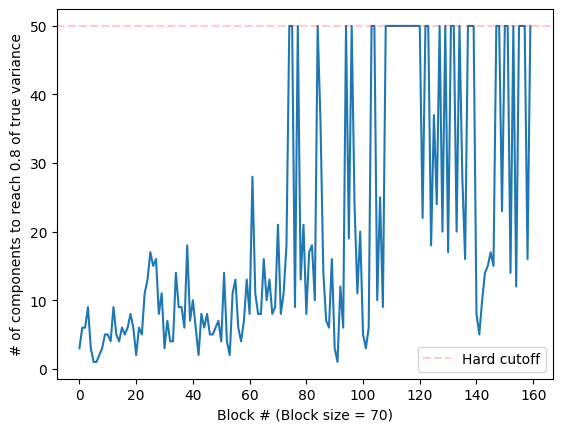

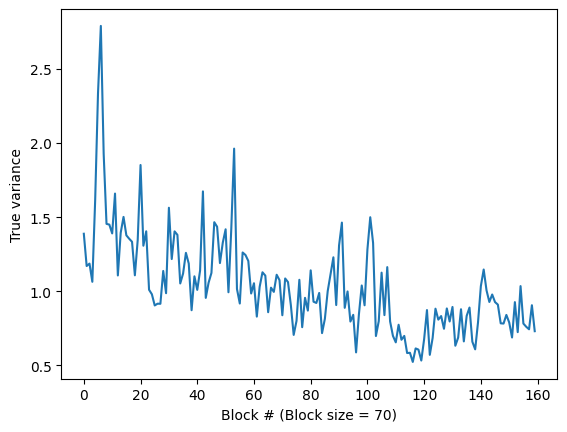

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


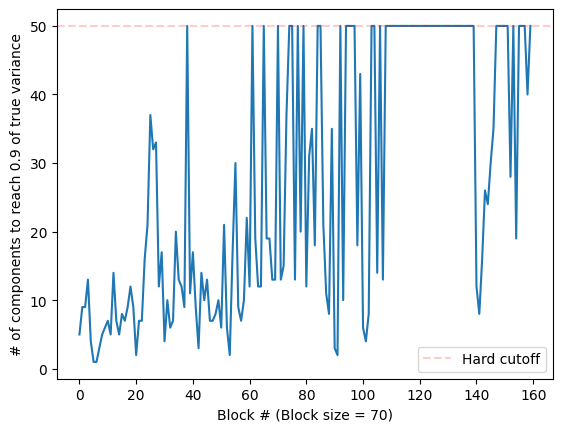

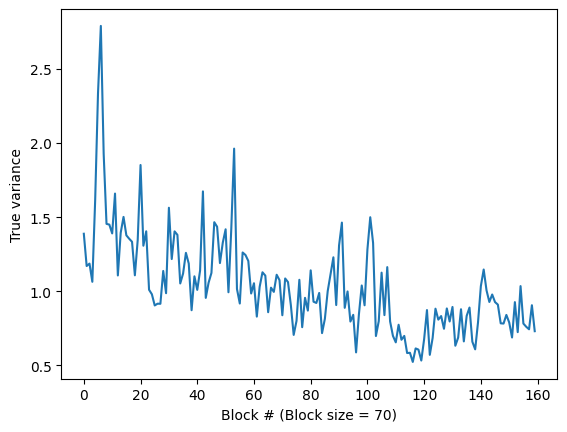

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


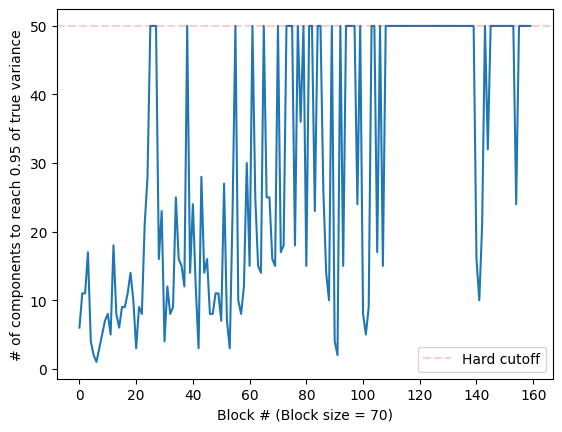

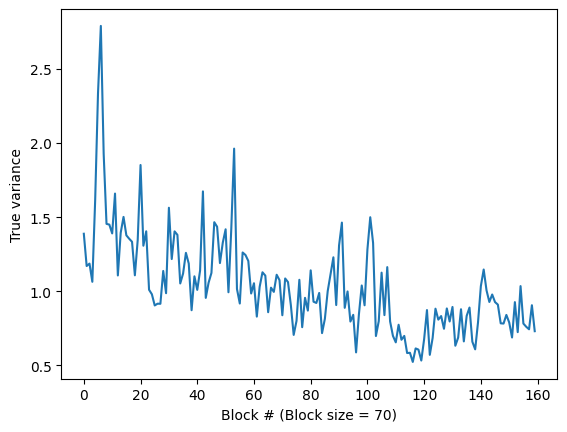

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


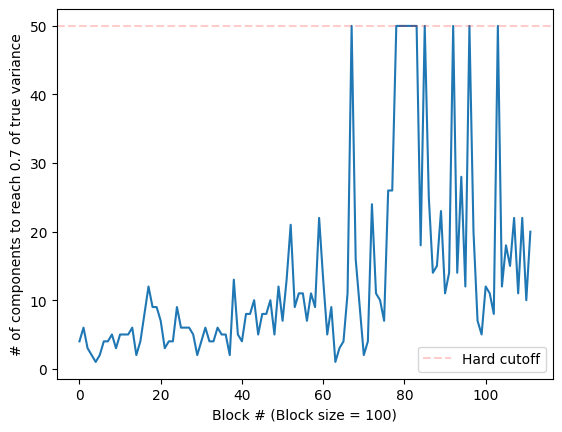

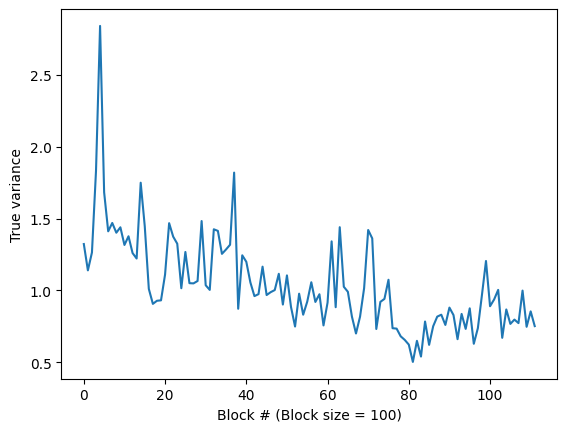

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


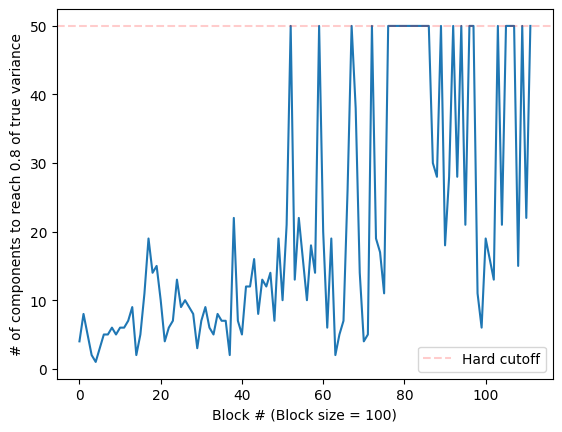

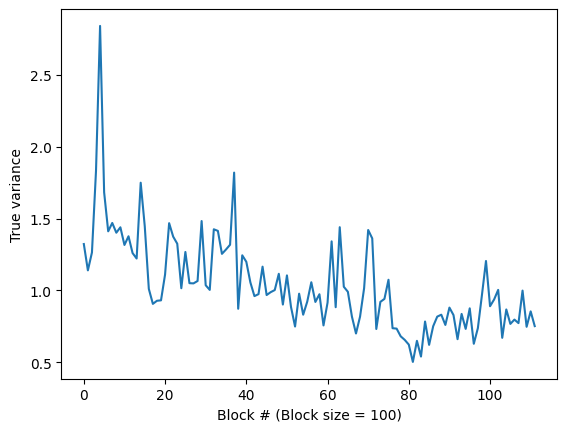

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


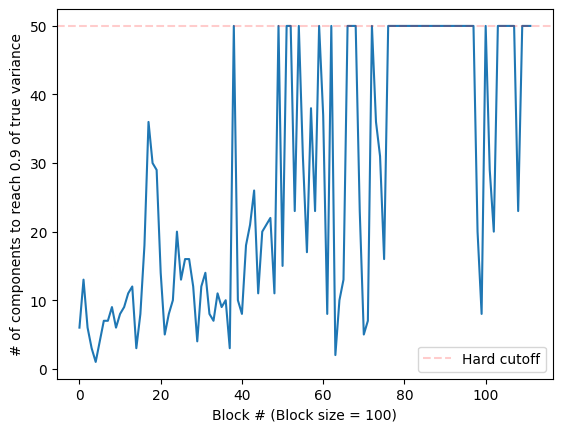

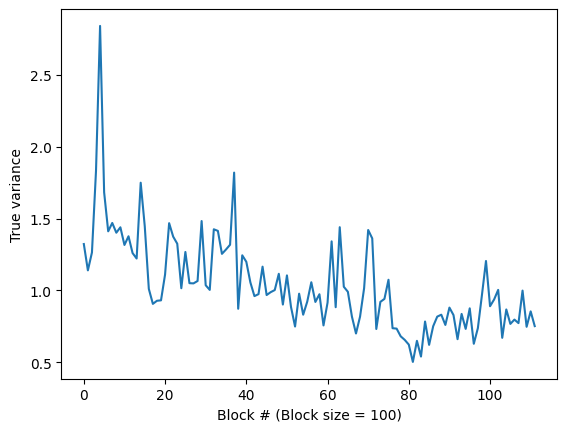

/Users/albertjan/miniconda/envs/iigayalab/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  warnings.warn(


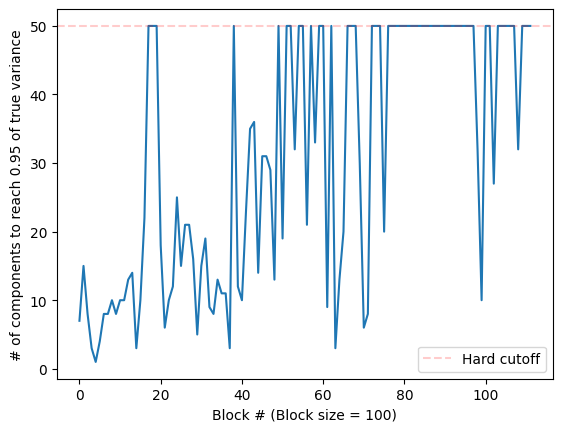

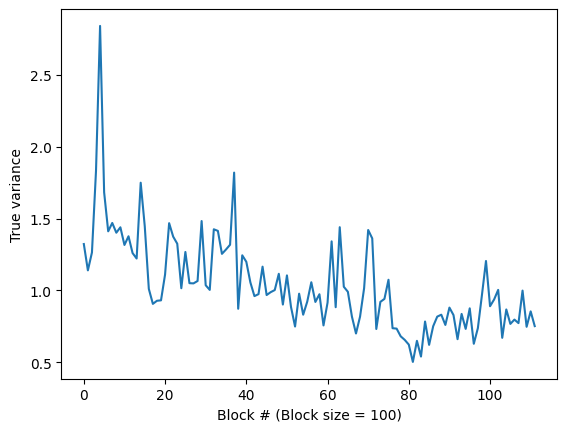

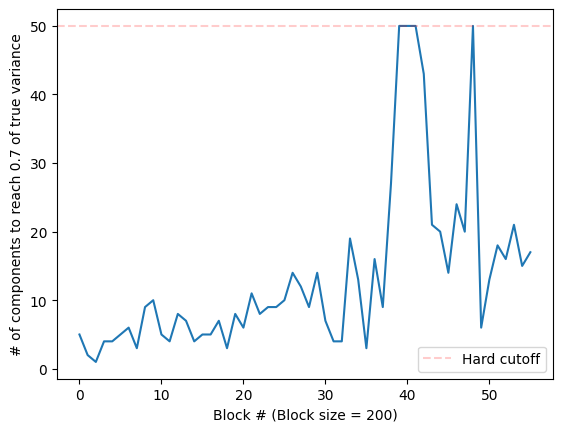

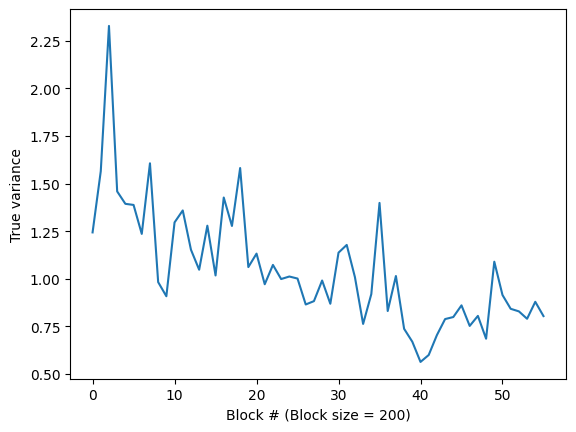

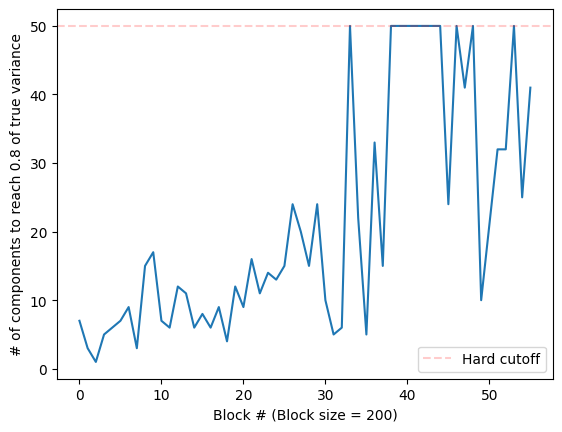

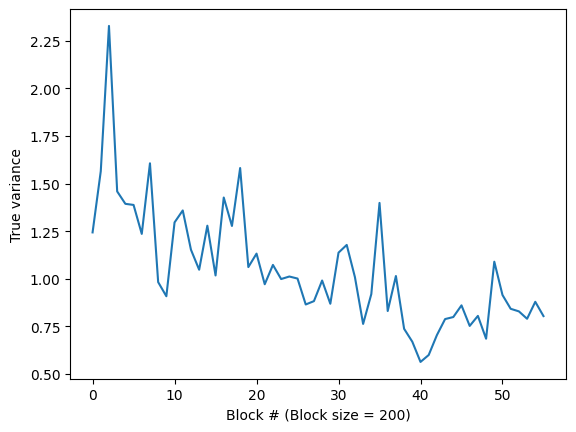

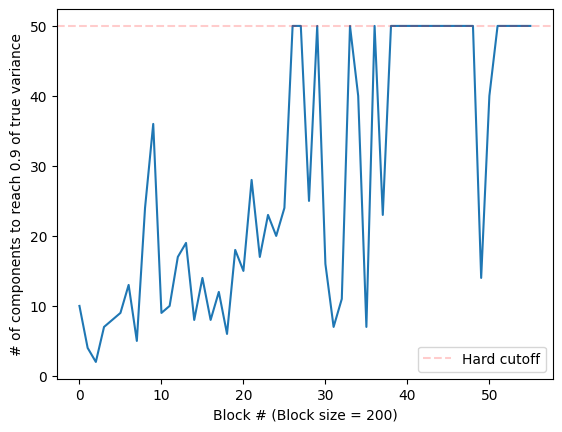

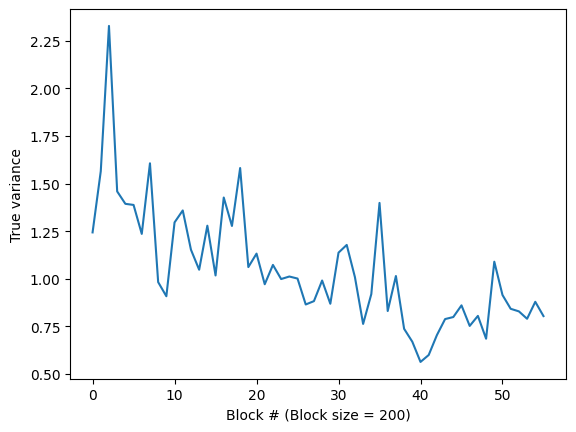

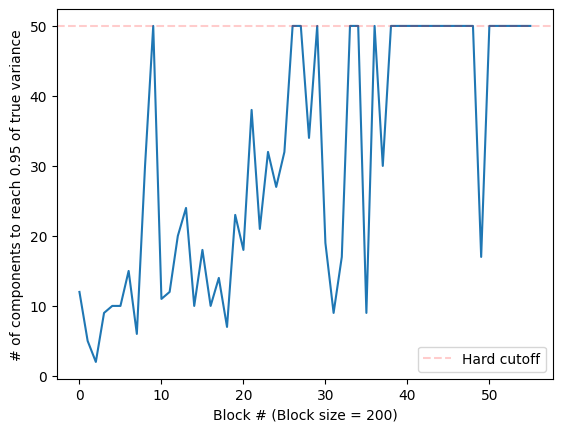

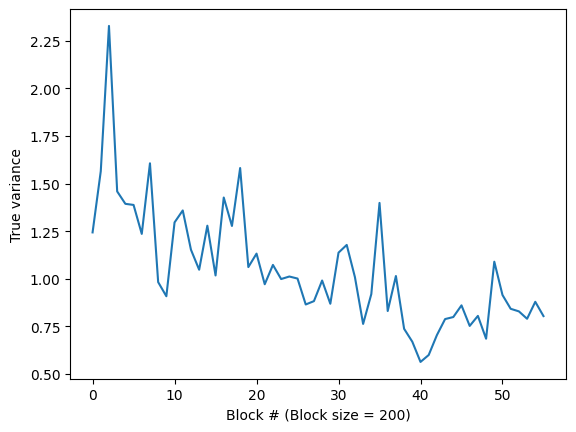

In [59]:
# Trying out some different block sizes and variance cutoffs
max_components=50
for block_sz in [70, 100, 200]:
    for variance_cutoff in [0.7, 0.8, 0.9, 0.95]:
        nmf_vars, true_vars, comps_needed = block_nmf(
            df=df,
            block_sz=block_sz,
            variance_cutoff=variance_cutoff,
            max_components=max_components
        )
        plt.plot(comps_needed)
        plt.axhline(
            y=max_components,
            color='r',
            linestyle='--',
            alpha=0.2,
            label="Hard cutoff"
        )
        plt.xlabel(f"Block # (Block size = {block_sz})")
        plt.ylabel(f"# of components to reach {variance_cutoff} of true variance")
        plt.legend()
        plt.show()

        plt.plot(true_vars)
        plt.xlabel(f"Block # (Block size = {block_sz})")
        plt.ylabel("True variance")
        plt.show()

